In [1]:
import sys
sys.path.append("../")

import os
os.chdir("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
from text_classification.models import LSTMClassifier, DistilBERTClassifier
from text_classification.datasets import SpamDetectionDataset

import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader, random_split

In [3]:
sns.set_theme()

# Spam detection

https://huggingface.co/datasets/FredZhang7/all-scam-spam

## Long short-term memory (LSTM)

In [4]:
# Model parameters
EMBEDDING_DIM = 100
HIDDEN_SIZE = 300
NUM_LAYERS = 1
DROPOUT = 0.2

# Training parameters
BATCH_SIZE = 256
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
PATIENCE = 5

In [5]:
dataset = SpamDetectionDataset("lstm")
train_data, val_data, test_data = random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [6]:
model = LSTMClassifier(
    num_classes=dataset.num_classes, 
    embedding_dim=EMBEDDING_DIM, 
    hidden_size=HIDDEN_SIZE, 
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT,
)
history = model.fit(train_loader, val_loader, LEARNING_RATE, NUM_EPOCHS, PATIENCE)
model.save("./models/spam_lstm.pt")

Epoch  1/50: loss=0.5888, accuracy=0.6856, precision=0.6910, recall=0.6501, f1_score=0.6484
Epoch  2/50: loss=0.4456, accuracy=0.8146, precision=0.8109, recall=0.8071, f1_score=0.8080
Epoch  3/50: loss=0.3734, accuracy=0.8449, precision=0.8406, recall=0.8435, f1_score=0.8410
Epoch  4/50: loss=0.3664, accuracy=0.8527, precision=0.8484, recall=0.8515, f1_score=0.8490
Epoch  5/50: loss=0.3409, accuracy=0.8627, precision=0.8586, recall=0.8614, f1_score=0.8591
Epoch  6/50: loss=0.3338, accuracy=0.8683, precision=0.8640, recall=0.8698, f1_score=0.8655
Epoch  7/50: loss=0.3195, accuracy=0.8722, precision=0.8683, recall=0.8736, f1_score=0.8695
Epoch  8/50: loss=0.2864, accuracy=0.8861, precision=0.8823, recall=0.8849, f1_score=0.8831
Epoch  9/50: loss=0.2902, accuracy=0.8823, precision=0.8782, recall=0.8853, f1_score=0.8801
Epoch 10/50: loss=0.2741, accuracy=0.8922, precision=0.8885, recall=0.8911, f1_score=0.8893
Epoch 11/50: loss=0.2333, accuracy=0.9096, precision=0.9076, recall=0.9063, f1_s

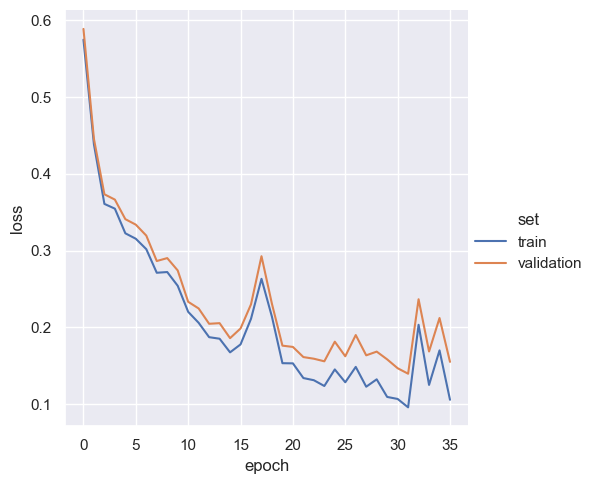

In [7]:
history = pd.DataFrame(history)
g = sns.relplot(history, x="epoch", y="loss", hue="set", kind="line")

In [8]:
y_true, y_pred = [], []
for _, _, labels, text in test_loader:
    y_true += labels.argmax(dim=1).tolist()
    y_pred += model.predict(text)
    
print("Classification report (test set)")
print(classification_report(y_true, y_pred, target_names=dataset.class_names, digits=4))

Classification report (test set)
              precision    recall  f1-score   support

     no_spam     0.9636    0.9620    0.9628      3794
        spam     0.9447    0.9469    0.9458      2598

    accuracy                         0.9559      6392
   macro avg     0.9541    0.9545    0.9543      6392
weighted avg     0.9559    0.9559    0.9559      6392



## DistilBERT

In [9]:
# Training parameters
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
NUM_EPOCHS = 10
PATIENCE = 2

In [10]:
dataset = SpamDetectionDataset("distilbert")
train_data, val_data, test_data = random_split(
    dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [11]:
model = DistilBERTClassifier(num_classes=dataset.num_classes)
history = model.fit(train_loader, val_loader, LEARNING_RATE, NUM_EPOCHS, PATIENCE)
model.save("./models/spam_distilbert.pt")

Epoch  1/10: loss=0.0483, accuracy=0.9848, precision=0.9853, recall=0.9844, f1_score=0.9837
Epoch  2/10: loss=0.0446, accuracy=0.9861, precision=0.9847, recall=0.9867, f1_score=0.9847
Epoch  3/10: loss=0.0493, accuracy=0.9873, precision=0.9861, recall=0.9877, f1_score=0.9858
Epoch  4/10: loss=0.0512, accuracy=0.9884, precision=0.9885, recall=0.9884, f1_score=0.9876
Epoch  5/10: loss=0.0786, accuracy=0.9841, precision=0.9826, recall=0.9847, f1_score=0.9824
Epoch  6/10: loss=0.1019, accuracy=0.9691, precision=0.9728, recall=0.9647, f1_score=0.9657
Early stopping - best model from epoch 4!


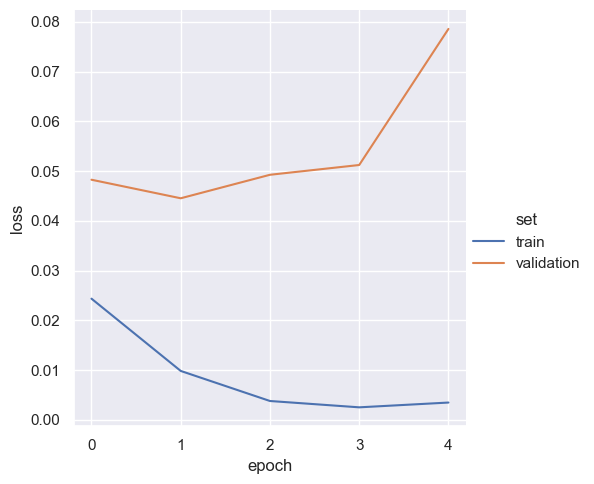

In [12]:
history = pd.DataFrame(history)
g = sns.relplot(history, x="epoch", y="loss", hue="set", kind="line")

In [13]:
y_true, y_pred = [], []
for _, _, labels, text in test_loader:
    y_true += labels.argmax(dim=1).tolist()
    y_pred += model.predict(text)

print("Classification report (test set)")
print(classification_report(y_true, y_pred, target_names=dataset.class_names, digits=4))

Classification report (test set)
              precision    recall  f1-score   support

     no_spam     0.9884    0.9924    0.9904      3794
        spam     0.9888    0.9831    0.9859      2598

    accuracy                         0.9886      6392
   macro avg     0.9886    0.9877    0.9882      6392
weighted avg     0.9886    0.9886    0.9886      6392

